# Imports & Configuration
DADASAHEB SAWANT THIS SIDE::
- We are going to discuss about how to read spark query plan. This is very fundamental to spark.
- This will help to understand HOW SPARK DOES THE THINGS INTERNALLY?
- And this is also very important to understand before you do ANY SPARK OPTIMIZATION..
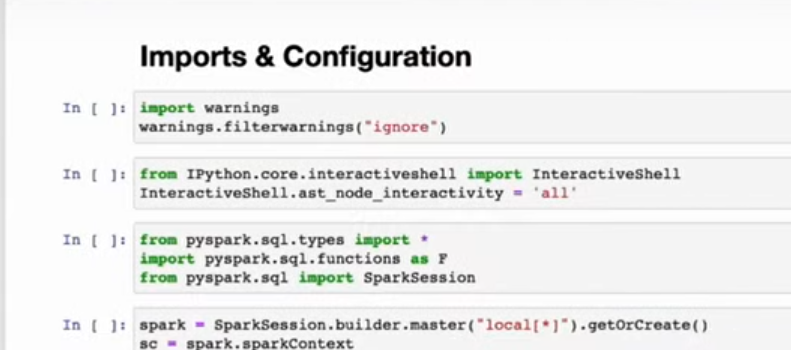

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

23/07/21 18:42:50 WARN Utils: Your hostname, Afaques-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.6 instead (on interface en0)
23/07/21 18:42:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/21 18:42:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Reading File

In [5]:
transactions_file = "../data/data_skew/transactions.parquet"
df_transactions = spark.read.parquet(transactions_file)

In [6]:
df_transactions.show(5, False)

+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|cust_id   |start_date|end_date  |txn_id         |date      |year|month|day|expense_type |amt   |city       |
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
|C0YDPQWPBJ|2010-07-01|2018-12-01|TZ5SMKZY9S03OQJ|2018-10-07|2018|10   |7  |Entertainment|10.42 |boston     |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYIAPPNU066CJ5R|2016-03-27|2016|3    |27 |Motor/Travel |44.34 |portland   |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TETSXIK4BLXHJ6W|2011-04-11|2011|4    |11 |Entertainment|3.18  |chicago    |
|C0YDPQWPBJ|2010-07-01|2018-12-01|TQKL1QFJY3EM8LO|2018-02-22|2018|2    |22 |Groceries    |268.97|los_angeles|
|C0YDPQWPBJ|2010-07-01|2018-12-01|TYL6DFP09PPXMVB|2010-10-16|2010|10   |16 |Entertainment|2.66  |chicago    |
+----------+----------+----------+---------------+----------+----+-----+---+-------------+------+-----------+
only showi

In [7]:
customers_file = "../data/data_skew/customers.parquet"
df_customers = spark.read.parquet(customers_file)

In [8]:
df_customers.show(5, False)

+----------+-------------+---+------+----------+-----+-----------+
|cust_id   |name         |age|gender|birthday  |zip  |city       |
+----------+-------------+---+------+----------+-----+-----------+
|C007YEYTX9|Aaron Abbott |34 |Female|7/13/1991 |97823|boston     |
|C00B971T1J|Aaron Austin |37 |Female|12/16/2004|30332|chicago    |
|C00WRSJF1Q|Aaron Barnes |29 |Female|3/11/1977 |23451|denver     |
|C01AZWQMF3|Aaron Barrett|31 |Male  |7/9/1998  |46613|los_angeles|
|C01BKUFRHA|Aaron Becker |54 |Male  |11/24/1979|40284|san_diego  |
+----------+-------------+---+------+----------+-----+-----------+
only showing top 5 rows



# Spark's Query Plans

Image Credits: `Databricks`

![Spark Execution](../data/spark-execution.png)

# Narrow Transformations
- `filter` rows where `city='boston'`
- `add` a new column: adding `first_name` and `last_name`
- `alter` an exisitng column: adding 5 to `age` column
- `select` relevant columns

In [9]:
df_narrow_transform = (
    df_customers
    .filter(F.col("city") == "boston")
    .withColumn("first_name", F.split("name", " ").getItem(0))
    .withColumn("last_name", F.split("name", " ").getItem(1))
    .withColumn("age", F.col("age") + F.lit(5))
    .select("cust_id", "first_name", "last_name", "age", "gender", "birthday")
)

df_narrow_transform.show(5, False)
df_narrow_transform.explain(True)

+----------+----------+---------+----+------+---------+
|cust_id   |first_name|last_name|age |gender|birthday |
+----------+----------+---------+----+------+---------+
|C007YEYTX9|Aaron     |Abbott   |39.0|Female|7/13/1991|
|C08XAQUY73|Aaron     |Lambert  |59.0|Female|11/5/1966|
|C094P1VXF9|Aaron     |Lindsey  |29.0|Male  |9/21/1990|
|C097SHE1EF|Aaron     |Lopez    |27.0|Female|4/18/2001|
|C0DTC6436T|Aaron     |Schwartz |57.0|Female|7/9/1962 |
+----------+----------+---------+----+------+---------+
only showing top 5 rows

== Parsed Logical Plan ==
'Project ['cust_id, 'first_name, 'last_name, 'age, 'gender, 'birthday]
+- Project [cust_id#67, name#68, (cast(age#69 as double) + cast(5 as double)) AS age#129, gender#70, birthday#71, zip#72, city#73, first_name#110, last_name#119]
   +- Project [cust_id#67, name#68, age#69, gender#70, birthday#71, zip#72, city#73, first_name#110, split(name#68,  , -1)[1] AS last_name#119]
      +- Project [cust_id#67, name#68, age#69, gender#70, birthday#7

# Wide Transformations
1. Repartition
2. Coalesce
3. Joins
4. GroupBy
   - `count`
   - `countDistinct`
   - `sum`

## 1. Repartition

In [10]:
df_transactions.rdd.getNumPartitions()

13

In [11]:
df_transactions.repartition(24).explain(True)

== Parsed Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 24, true
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Exchange RoundRobinPartitioning(24), REPARTITION_BY_NUM, [id=#72]
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Location: I

## 2. Coalesce

In [12]:
df_transactions.coalesce(5).explain(True)

== Parsed Logical Plan ==
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Repartition 5, false
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
Coalesce 5
+- *(1) ColumnarToRow
   +- FileScan parquet [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/Users/afaqueahmad/Documents/youtube/spar

### Why doesn't `.coalesce()` explicitly show the partitioning scheme?

`.coalesce` doesn't show the partitioning scheme e.g. `RoundRobinPartitioning` because: 
- The operation only minimizes data movement by merging into fewer partitions, it doesn't do any shuffling.
- Because no shuffling is done, the partitioning scheme remains the same as the original DataFrame and Spark doesn't include it explicitly in it's plan as the partitioning scheme is unaffected by `.coalesce`

## 3. Joins

In [13]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [14]:
df_joined = (
    df_transactions.join(
        df_customers,
        how="inner",
        on="cust_id"
    )
)

In [15]:
df_joined.explain(True)

== Parsed Logical Plan ==
'Join UsingJoin(Inner,Buffer(cust_id))
:- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet
+- Relation [cust_id#67,name#68,age#69,gender#70,birthday#71,zip#72,city#73] parquet

== Analyzed Logical Plan ==
cust_id: string, start_date: string, end_date: string, txn_id: string, date: string, year: string, month: string, day: string, expense_type: string, amt: string, city: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string
Project [cust_id#0, start_date#1, end_date#2, txn_id#3, date#4, year#5, month#6, day#7, expense_type#8, amt#9, city#10, name#68, age#69, gender#70, birthday#71, zip#72, city#73]
+- Join Inner, (cust_id#0 = cust_id#67)
   :- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet
   +- Relation [cust_id#67,name#68,age#69,gender#70,birthday#71,zip#72,city#73] parquet

== O

## 4. GroupBy

In [16]:
df_transactions.printSchema()

root
 |-- cust_id: string (nullable = true)
 |-- start_date: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- txn_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- expense_type: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- city: string (nullable = true)



### GroupBy Count

In [17]:
df_city_counts = (
    df_transactions
    .groupBy("city")
    .count()
)

In [18]:
df_city_counts.explain(True)

== Parsed Logical Plan ==
'Aggregate ['city], ['city, count(1) AS count#199L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
city: string, count: bigint
Aggregate [city#10], [city#10, count(1) AS count#199L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [city#10], [city#10, count(1) AS count#199L]
+- Project [city#10]
   +- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[city#10], functions=[count(1)], output=[city#10, count#199L])
   +- Exchange hashpartitioning(city#10, 200), ENSURE_REQUIREMENTS, [id=#131]
      +- HashAggregate(keys=[city#10], functions=[partial_count(1)], output=[city#10, count#203L])
         +- File

In [19]:
df_txn_amt_city = (
    df_transactions
    .groupBy("city")
    .agg(F.sum("amt").alias("txn_amt"))
)

In [20]:
df_txn_amt_city.explain(True)

== Parsed Logical Plan ==
'Aggregate ['city], ['city, sum('amt) AS txn_amt#216]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
city: string, txn_amt: double
Aggregate [city#10], [city#10, sum(cast(amt#9 as double)) AS txn_amt#216]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [city#10], [city#10, sum(cast(amt#9 as double)) AS txn_amt#216]
+- Project [amt#9, city#10]
   +- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[city#10], functions=[sum(cast(amt#9 as double))], output=[city#10, txn_amt#216])
   +- Exchange hashpartitioning(city#10, 200), ENSURE_REQUIREMENTS, [id=#144]
      +- HashAggregate(keys=[city#10], function

### GroupBy Count Distinct 

In [21]:
df_txn_per_city = (
    df_transactions
    .groupBy("cust_id")
    .agg(F.countDistinct("city").alias("city_count"))
)

In [22]:
df_txn_per_city.show(5, False)
df_txn_per_city.explain(True)

+----------+----------+
|cust_id   |city_count|
+----------+----------+
|CPP8BY8U93|10        |
|CYB8BX9LU1|10        |
|CFRT841CCD|10        |
|CA0TSNMYDK|10        |
|COZ8NONEVZ|10        |
+----------+----------+
only showing top 5 rows

== Parsed Logical Plan ==
'Aggregate ['cust_id], ['cust_id, 'count(distinct 'city) AS city_count#232]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Analyzed Logical Plan ==
cust_id: string, city_count: bigint
Aggregate [cust_id#0], [cust_id#0, count(distinct city#10) AS city_count#232L]
+- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

== Optimized Logical Plan ==
Aggregate [cust_id#0], [cust_id#0, count(distinct city#10) AS city_count#232L]
+- Project [cust_id#0, city#10]
   +- Relation [cust_id#0,start_date#1,end_date#2,txn_id#3,date#4,year#5,month#6,day#7,expense_type#8,amt#9,city#10] parquet

==

# 5. Interesting Observations

### Why is a filter step present despite predicate pushdown? 

This is largely due to the way `Spark's Catalyst Optimizer` works. Specifically, due to two separate stages of the query optimization process: Physical Planning and Logical Planning.

- **Logical Planning**: Catalyst optimizer simplifies the unresolved logical plan (which represents the user's query) by applying various rule-based optimizations. This includes `predicate pushdown`, `projection pushdown` where filter conditions and column projections are moved as close to the data source as possible.

- **Physical Planning** phase is where the logical plan is translated into one or more physical plans, which can actually be executed on the cluster. This includes operations like file `scans`, `filters`, `projections`, etc.

In this case, during the logical planning phase, the predicate (`F.col("city") == "boston"`) has been pushed down and will be applied during the scan of the Parquet file (`PushedFilters: [IsNotNull(city), EqualTo(city,boston)]`), thus improving performance.

Now, during the physical planning phase, the same filter condition (`+- *(1) Filter (isnotnull(city#73) AND (city#73 = boston))`) is applied again to the data that's been loaded into memory. This is because of the following reasons:

1. **Guaranteed Correctness:** It might seem **redundant**, but remember that not all data sources can handle pushed-down predicates, and not all predicates can be pushed down. Therefore, **even if a predicate is pushed down to the data source, Spark still includes the predicate in the physical plan** to cover cases where the data source might not have been able to fully apply the predicate. This is Spark's way of making sure the correct data is always returned, no matter the capabilities of the data source.

2. **No Assumptions**: Spark's Catalyst optimizer doesn't make assumptions about the data source's ability to handle pushed-down predicates. The optimizer aims to generate plans that return correct results across a wide range of scenarios. Even if the filter is pushed down, Spark does not have the feedback from data source whether the pushdown was successful or not, so it includes the filter operation in the physical plan as well.

It is more of a **fail-safe mechanism** to ensure data **integrity** and **correctness**.

---

### In what cases will predicate pushdown not work?

2 Examples where **filter pushdown** will not work:

1. **Complex Data Types**: Spark's Parquet data source does not push down filters that involve **complex types**, such as **arrays**, **maps**, and **structs**. This is because these complex data types can have complicated nested structures that the Parquet reader cannot easily filter on.

Here's an example:

```
root
 |-- Name: string (nullable = true)
 |-- properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)

+----------+-----------------------------+
|Name      |properties                   |
+----------+-----------------------------+
|Afaque    |[eye -> black, hair -> black]|
|Naved     |[eye ->, hair -> brown]      |
|Ali       |[eye -> black, hair -> red]  |
|Amaan     |[eye -> grey, hair -> grey]  |
|Omaira    |[eye -> , hair -> brown]     |
+----------+-----------------------------+
```

```python
df.filter(df.properties.getItem("eye") == "brown").show()
```

```
== Physical Plan ==
*(1) Filter (metadata#123[key] = value)
+- *(1) ColumnarToRow
   +- FileScan parquet [id#122,metadata#123] Batched: true, DataFilters: [(metadata#123[key] = value)], Format: Parquet, ...
```

------------------------------------------------

3. Unsupported Expressions: 

In Spark, `Parquet` data source does not support pushdown for filters involving a `.cast` operation. The reason for this behaviour is as follows:
- `.cast` changes the datatype of the column, and the Parquet data source may not be able to perform the filter operation correctly on the cast data.

**Note**: This behavior may vary based on the data source. For example, if you're working with a JDBC data source connected to a database that supports SQL-like operations, the `.cast` filter could potentially be pushed down to the database.

### Example of operation where filter pushdown doesn't work

In [23]:
df_customer_gt_50 = (
    df_customers
    .filter(F.col("age").cast("int") > 50)
)
df_customer_gt_50.show(5, False)
df_customer_gt_50.explain(True)

+----------+--------------+---+------+----------+-----+------------+
|cust_id   |name          |age|gender|birthday  |zip  |city        |
+----------+--------------+---+------+----------+-----+------------+
|C01BKUFRHA|Aaron Becker  |54 |Male  |11/24/1979|40284|san_diego   |
|C01WMZQ7PN|Aaron Brady   |51 |Female|8/20/1994 |52204|philadelphia|
|C021567NJZ|Aaron Briggs  |57 |Male  |3/10/1990 |22008|philadelphia|
|C02JNTM46B|Aaron Chambers|51 |Male  |1/6/2001  |63337|new_york    |
|C030A69V1L|Aaron Clarke  |55 |Male  |4/28/1999 |77176|philadelphia|
+----------+--------------+---+------+----------+-----+------------+
only showing top 5 rows

== Parsed Logical Plan ==
'Filter (cast('age as int) > 50)
+- Relation [cust_id#67,name#68,age#69,gender#70,birthday#71,zip#72,city#73] parquet

== Analyzed Logical Plan ==
cust_id: string, name: string, age: string, gender: string, birthday: string, zip: string, city: string
Filter (cast(age#69 as int) > 50)
+- Relation [cust_id#67,name#68,age#69,gend